In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))
from volatility_pipeline import *

import torch
torch.set_grad_enabled(True)

In [2]:
# Configuration parameters
FETCH_DATA = False  # Set to True to fetch new news data
FROM = "2023-01-01"
TO = "2025-05-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "CAC 40"
WINDOW = 7
EPOCHS = 200

In [3]:
# Define relevant keywords for CAC 40 news
keywords = [
    "cac40",  # French stock index (equivalent to DAX)
    "inflation",  # Inflation (same in French)
    "taux d'intérêt",  # Interest rates
    "tarifs",  # Tariffs
    "croissance économique",  # Economic growth
    "récession",  # Recession
    "chômage",  # Unemployment
    "subventions",  # Subsidies (same in French)
    "investissement",  # Investment
    "expansion"  # Expansion (same in French)
]

KEYWORDS = " OR ".join([f'"{keyword}"' for keyword in keywords])

In [4]:
import pandas as pd, time, random
from pygooglenews import GoogleNews

# Fetch news data function
def fetch_cac_news_data():
    gn = GoogleNews(lang="fr", country="FR")

    all_frames = []

    start_dt = pd.to_datetime(FROM)
    end_dt   = pd.to_datetime(TO)

    while start_dt <= end_dt:
        stop_dt = min(start_dt + pd.Timedelta(days=WINDOW-1), end_dt)

        feed    = gn.search(KEYWORDS,
                            from_=start_dt.strftime("%Y-%m-%d"),
                            to_  =stop_dt.strftime("%Y-%m-%d"))

        df      = pd.DataFrame(
                    {"date":  [pd.to_datetime(e.published).tz_localize(None)
                                for e in feed["entries"]],
                    "title": [e.title for e in feed["entries"]]}
                )
        all_frames.append(df)

        # polite pause to avoid 429 errors
        time.sleep(random.uniform(1.0, 2.5))
        start_dt = stop_dt + pd.Timedelta(days=1)

    news_df = (pd.concat(all_frames, ignore_index=True)
                .drop_duplicates())          # remove overlaps
    
    # Remove the "- name of the news source" suffix from titles
    news_df['title'] = news_df['title'].str.replace(r' - .+$', '', regex=True)
    

    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    news_df.to_csv(f"../news/news_data_{FROM}_{TO}_CAC.csv", index=False)
    
    return news_df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_cac_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_CAC.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Loaded 12382 news articles


In [6]:
import yfinance

# Fetch CAC 40 market data using yfinance
cac40 = yfinance.Ticker("^FCHI")
cac40_data = cac40.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
cac40_data = cac40_data.reset_index()  # Convert index to column
cac40_data["Returns"] = cac40_data["Close"].pct_change()
cac40_data["Volatility"] = cac40_data["Returns"].rolling(window=21).std() * np.sqrt(252)
cac40_data = cac40_data.dropna().reset_index(drop=True)

# Remove hours from the date
cac40_data["Date"] = cac40_data["Date"].dt.date
# Remove hours from the date in news_df
news_df["date"] = news_df["date"].dt.date

print(f"Loaded {len(cac40_data)} days of CAC 40 market data")
cac40_data.head()

Loaded 594 days of CAC 40 market data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Volatility
0,2023-01-31,7075.089844,7088.970215,7025.529785,7082.419922,78055900,0.0,0.0,0.000058,0.126844
1,2023-02-01,7087.200195,7110.209961,7059.609863,7077.109863,63651600,0.0,0.0,-0.000750,0.127596
2,2023-02-02,7110.029785,7184.689941,7079.410156,7166.270020,95949900,0.0,0.0,0.012598,0.111226
3,2023-02-03,7136.399902,7233.939941,7113.419922,7233.939941,89988400,0.0,0.0,0.009443,0.112082
4,2023-02-06,7181.970215,7187.270020,7104.520020,7137.100098,68293300,0.0,0.0,-0.013387,0.117977


Splitting data at 2024-10-01...
Sentiment model loaded on device: cuda
GPU: NVIDIA GeForce RTX 4070
Calculating enhanced sentiment scores...
Computing sentiment predictions from scratch...
Processing 12382 news titles in batches of 32
Computed and cached sentiment predictions for 871 dates
Plotting sentiment distribution...


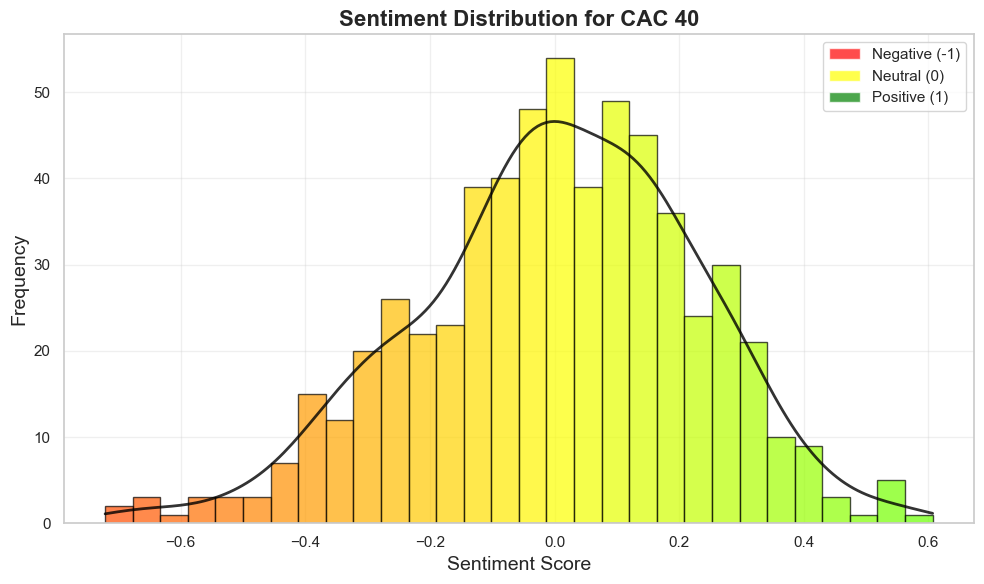

Final feature columns for model: ['Volatility_Smooth', 'sentiment_vol', 'sentiment_mean_5d', 'sentiment_std_5d', 'sentiment_mean_7d', 'sentiment_std_7d']


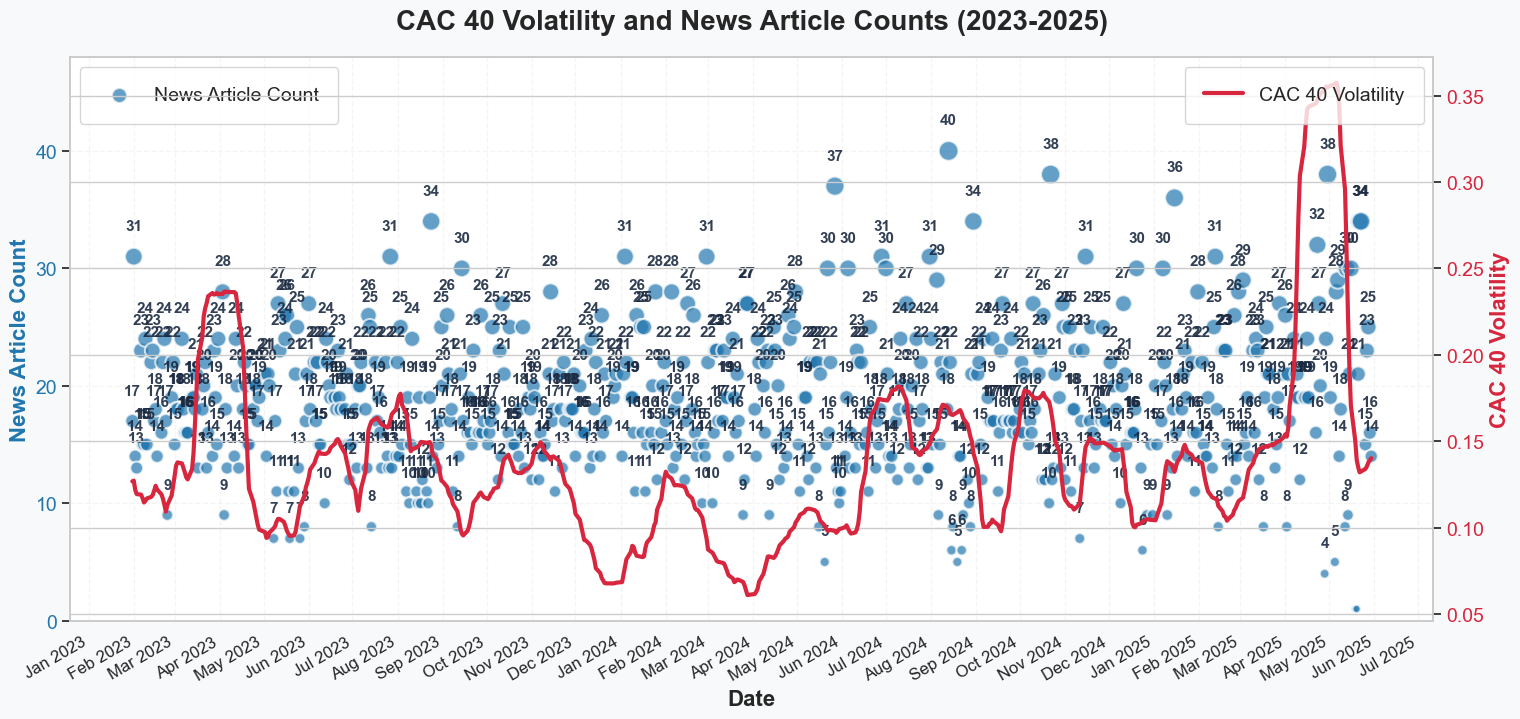

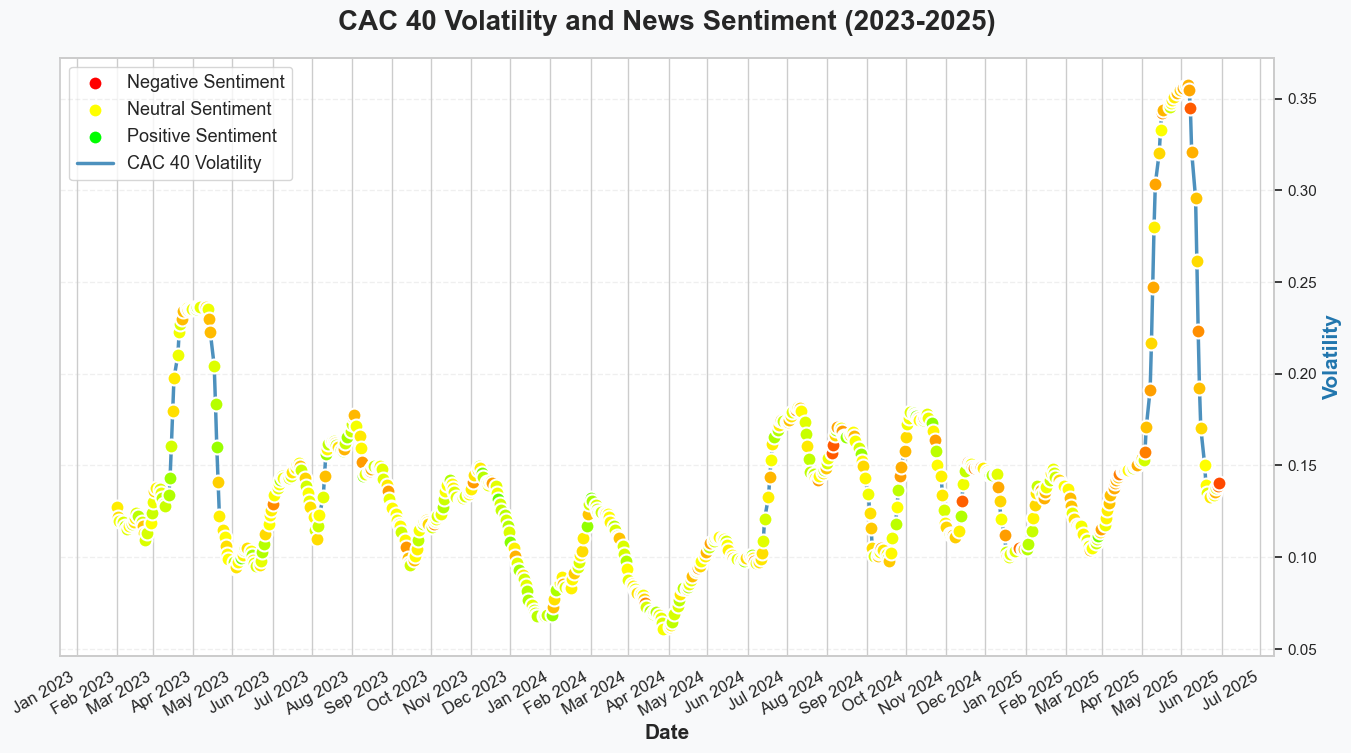

Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 5314 trainable parameters
Epoch 1/200, Train Loss: 0.22851, Val Loss: 0.12355
Epoch 10/200, Train Loss: 0.00789, Val Loss: 0.00442
Epoch 20/200, Train Loss: 0.00535, Val Loss: 0.00478
Early stopping at epoch 24
Evaluating enhanced LSTM model...
Model Performance Metrics:
MSE: 0.000682
RMSE: 0.026113
MAE: 0.016709
R² Score: 0.866158


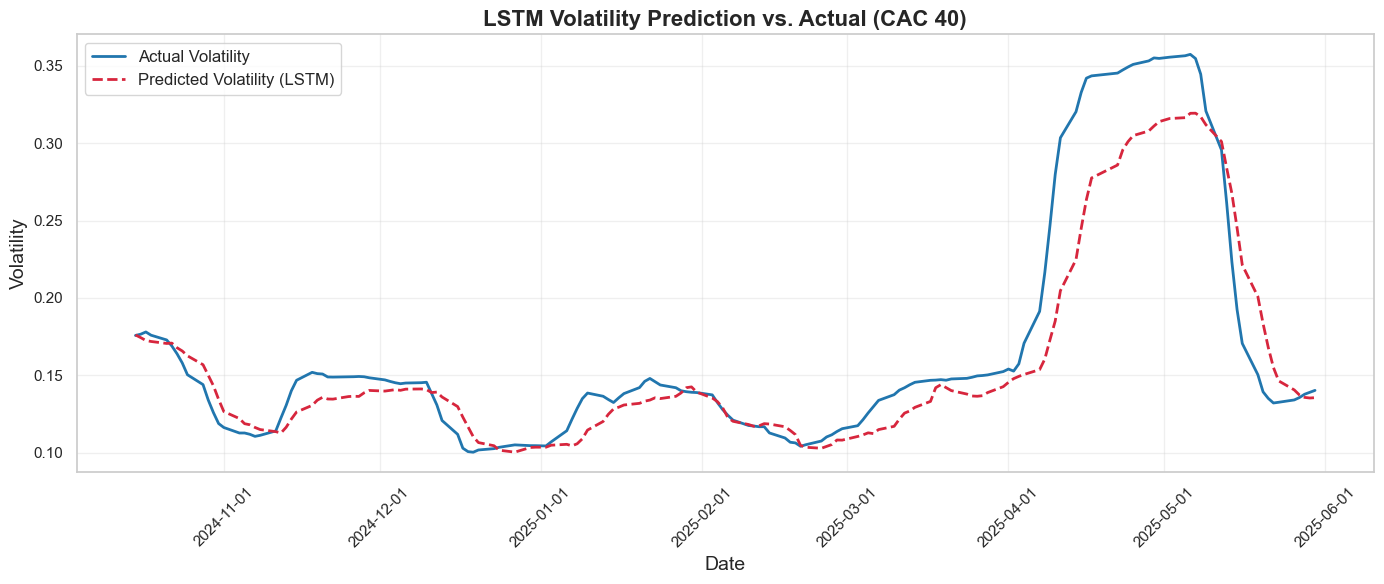

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=cac40_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    epochs=EPOCHS,
)